##Loading and Importing Libraries


In [1]:
!pip install tensorflow scikeras matplotlib scikit-learn

INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.


In [2]:
import pandas
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Concatenate, Input, Lambda, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

##Importing Data


In [3]:
import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "http://frasca.di.unimi.it/MLDNN/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"
#Then use the following lines to read it:
import pickle as pk
with open(data_path, 'rb') as f:
    dd = pk.load(f)

imgs = dd['imgs']
masks = dd['masks']

In [4]:
imgs.shape, masks.shape

((1305, 256, 256, 3), (1305, 256, 256, 1))

Now, I plot some random images with their relative mask to get to understand the context of the task

In [5]:
def plot_img(idx):
  fig, axs = plt.subplots(1, 2)
  axs[0].imshow(imgs[idx])
  axs[1].imshow(masks[idx])

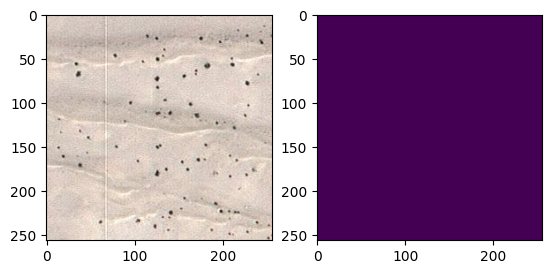

In [6]:
idx = random.randint(0, imgs.shape[0]-1)
plot_img(idx)

So, the images are urban images and the goal is to locate different elements of the urban environment

##Data Preprocessing

Values of the images pixels

In [7]:
imgs.max(), imgs.min()

(255, 0)

Values of the masks pixels

In [8]:
masks.max(), masks.min()

(5, 0)

Rescale images values in the [0,1] interval

In [9]:
imgs.dtype

dtype('uint8')

In [10]:
imgs = imgs.astype('float64')

In [11]:
imgs /= 255
imgs.max(), imgs.min()

(1.0, 0.0)

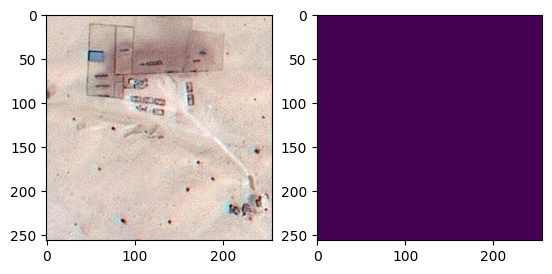

In [12]:
plot_img(random.randint(0,imgs.shape[0]-1))

In [13]:
img_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3])

In [14]:
n_classes = len(np.unique(masks))

##Classes balance

In [15]:
unique, counts = np.unique(masks, return_counts=True)
print(np.asarray((unique, counts)).T)

[[       0 11698953]
 [       1 45571963]
 [       2  7985171]
 [       3  8743823]
 [       4 11116730]
 [       5   407840]]


I display the value counts of each class in a bar diagram, it is clear the unbalance in the dataset

<BarContainer object of 6 artists>

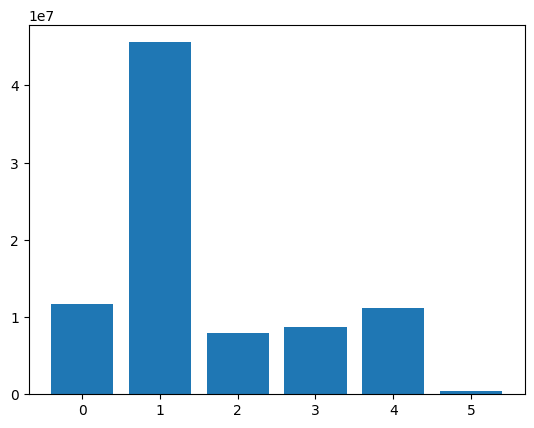

In [16]:
plt.bar(x=unique, height=counts)

Class 5 is heavily under represented while class 1 is over represented, so I will adjust class weights in the loss function accordingly

##Train-Test Splitting

In [17]:
X_train, X_test, y_train, y_test = train_test_split(imgs, masks, test_size=.2)

In [18]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1044, 256, 256, 3) (261, 256, 256, 3)
(1044, 256, 256, 1) (261, 256, 256, 1)


##Classes weights

In [19]:
class_weights = compute_class_weight('balanced', classes=np.unique(masks), y=y_train.reshape(-1))
class_weights

array([ 1.20997755,  0.31187879,  1.78765787,  1.66330537,  1.28823584,
       32.99736965])

In [20]:
class_weights = {i:weight for i, weight in enumerate(class_weights) }
class_weights

{0: 1.2099775475469952,
 1: 0.31187878673837754,
 2: 1.787657874377732,
 3: 1.66330536911528,
 4: 1.288235842358288,
 5: 32.99736964705814}

##Custom Utility Functions and Classes

Custom Intersection over Union in order to use it also as training metric

In [21]:
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=None, name=None, dtype=None):
        super(CustomMeanIoU, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

General function to get class weights to train the model given the labels

In [22]:
def get_class_weights(y):
  class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y.reshape(-1))
  class_weights = {i:weight for i, weight in enumerate(class_weights) }

  return class_weights

Function to evaluate accuracy and Intersection over Union of a model on a validation set

In [23]:
def evaluate_model(model, X_tra, y_tra, X_val, y_val, class_weights, batch_size, epochs):
  model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, class_weight=class_weights)
  val_loss, val_acc, val_iou = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)

  clear_session()

  return val_loss, val_acc, val_iou

Function to visualize real imagem real label, predicted label

In [24]:
def visualize_predictions(X_true, y_true, y_pred, idx):
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(X_true[idx])
    axs[0].set_title("Image")
    axs[1].imshow(y_true[idx])
    axs[1].set_title("Ground Truth")
    axs[2].imshow(y_pred[idx])
    axs[2].set_title("Prediction")
    plt.show()

Functions to plot the learning curve of a model and its confusion matrix

In [25]:
def plot_learning_curve(history):
  plt.figure(figsize=(12, 4))

  # Plot training and validation loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Plot training and validation accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

In [26]:
def plot_confusion_matrix(y_true, y_pred, num_classes):
  # Compute the confusion matrix
  cm = confusion_matrix(y_test.reshape(-1), y_pred.numpy().reshape(-1))

  # Plot the confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Class {i}' for i in range(num_classes)])
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()

##Model Architecture
I'm using a Fully Convolutional Neural Network to solve the task, having both as input and as output images. So I have to build the structure of the encoder and that of the decoder, connecting them through a bottleneck. For this scope I will only include in the network layers of the following kinds: Conv2d, MaxPool2d, Conv2dTranspose and Concatenate layers to include the skip connections in the network.
I will firstly define a convolutional block and an transpose convolutional block which I will use as main components respectively of the encoder and of the decoder; in this way it will be easier to scale up the model if needed

**Also, as comments, I added Bropout and BatchNormalization layers which could help reaching better results in the long run, I didn't actually add them to my model since I did not talk about them in the written part of the exam, but I wanted to highlight that they might be helpful in a unconstrained setting**

In [27]:
# CONVOLUTIONAL BLOCK
# I'm assuming that the blocks have a fixed number of layers (2 Conv2D, 1 MaxPool2D)
# and that all the layers in the block have the same number of filters (n_filters)
# Dropout and BatchNormalization layer because they are possible ways to get a better model but I did not mention them in the written part of the exam

def convolutional_block(x, n_filters:int, kernel_size:tuple[int]=(3, 3), padding:str="same", pool_size:tuple[int]=(2,2)):
  conv = Conv2D(n_filters, kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(x)
  #conv = Dropout(.3)(conv)
  conv = Conv2D(n_filters, kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(conv)
  #conv = BatchNormalization()(conv, training=False)

  pool = MaxPool2D(pool_size=pool_size)(conv)

  return conv, pool

# TRANSPOSE CONVOLUTIONAL BLOCK
# I'm assuming that the blocks have a fixed number of layers (1 Conv2DTranspose, 2 Conv2D + skip connection)
# and that all the Conv2D layers in the block have the same number of filters (n_filters_conv);

def transpose_block(x, skip, n_filters:int, kernel_size:tuple[int]=(3, 3), padding:str="same", stride_trans:tuple[int]=(2,2)):
  trans_conv = Conv2DTranspose(n_filters, kernel_size=(2,2), strides=stride_trans, padding=padding)(x)
  conc = Concatenate()([skip, trans_conv])
  conv = Conv2D(n_filters, kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(conc)
  #conv = Dropout(.3)(conv)
  conv = Conv2D(n_filters, kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(conv)

  return conv

In [28]:
def FCNN(img_shape:tuple[int], n_classes:int, n_filters_list:list[int], \
         kernel_size:tuple[int]=(3, 3), padding:str="same", pool_size:tuple[int]=(2,2)):
  input = Input(shape=img_shape)
  conv_layers = []
  pool_layers = []
  decoder_layers = []

  # ENCODER
  for i, n_filters in enumerate(n_filters_list):
    if i == 0:
      conv, pool = convolutional_block(input, n_filters, kernel_size, padding, pool_size)
      conv_layers.append(conv)
      pool_layers.append(pool)
    else:
      conv, pool = convolutional_block(pool_layers[-1], n_filters, kernel_size, padding, pool_size)
      conv_layers.append(conv)
      pool_layers.append(pool)

  # BOTTLENECK
  # I'm assuming a fixed size bottleneck with 2 layers
  # with the same number of filters of the last encoding block (or first decoding block)
  bot = Conv2D(n_filters_list[-1], kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(pool_layers[-1])
  bot = Conv2D(n_filters_list[-1], kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(bot)

  # DECODER
  for i, n_filters in enumerate(n_filters_list):
    if i == 0:
      conv = transpose_block(bot, conv_layers[-(i+1)], n_filters_list[-(i+1)], kernel_size, padding)
      decoder_layers.append(conv)
    else:
      conv = transpose_block(decoder_layers[-1], conv_layers[-(i+1)], n_filters_list[-(i+1)], kernel_size, padding)
      decoder_layers.append(conv)

  # OUTPUT layers
  output = Conv2D(n_classes, kernel_size=(1,1), padding=padding, activation='softmax')(decoder_layers[-1])

  model = Model(inputs=[input], outputs=[output])
  model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', CustomMeanIoU(num_classes=n_classes, name='IoU')])
  return model

##Base Model
Now I train a base model and evaluate his performance to keep it as term of comparison later in the work. In this stage I'm not trying to optimize any parameter.

In [29]:
n_filters_list = [16, 32, 64]
model = FCNN(img_shape=img_shape,
             n_classes=n_classes,
             n_filters_list=n_filters_list)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

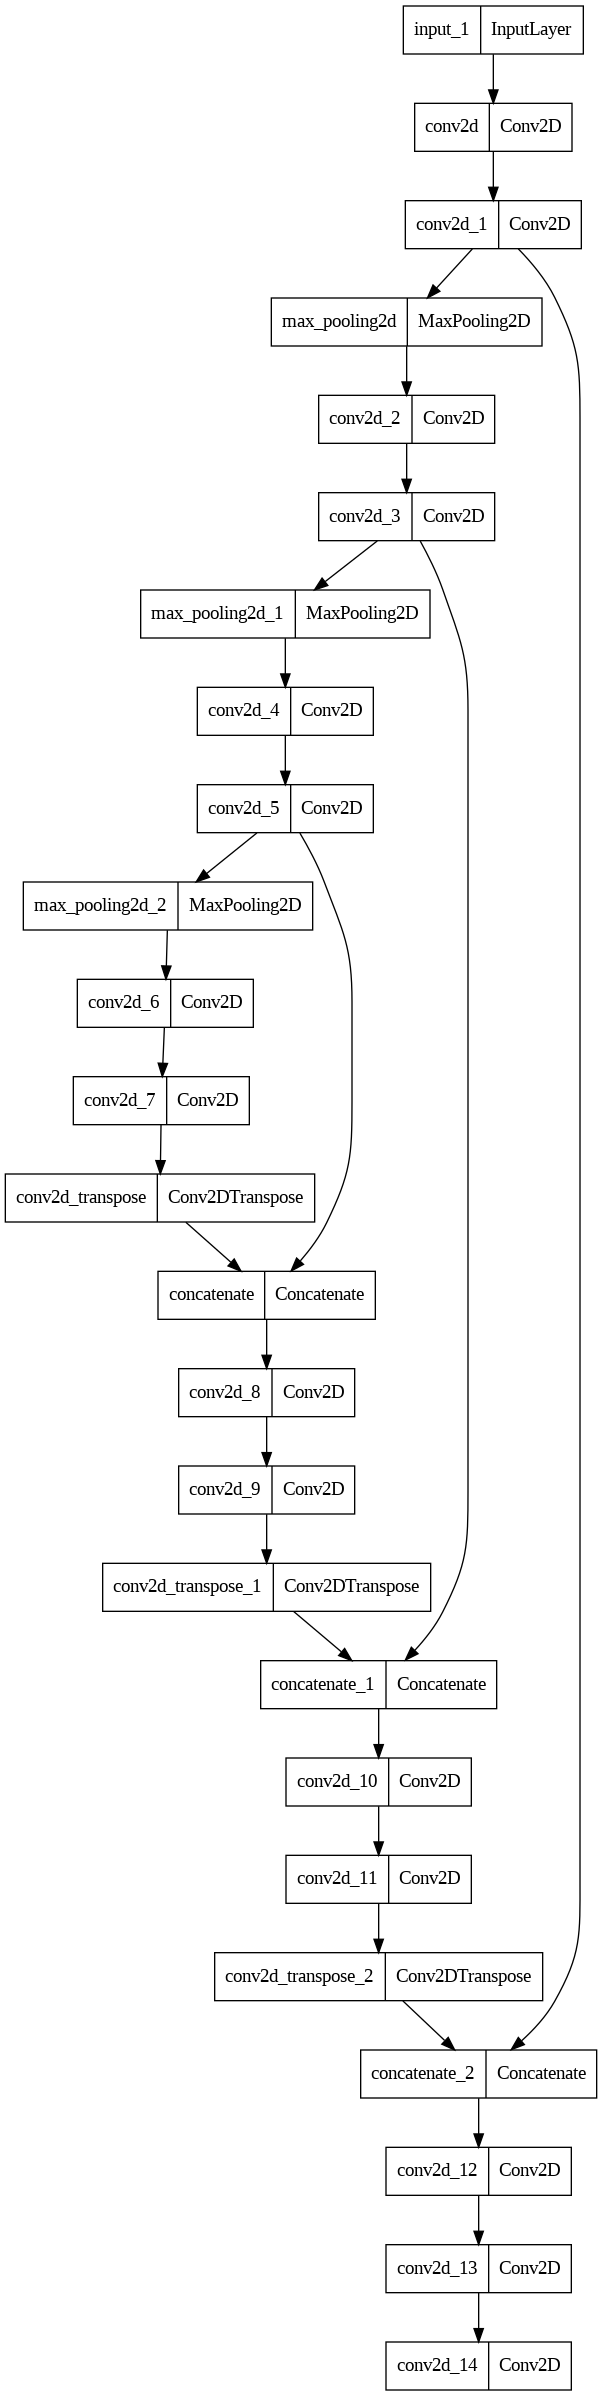

In [30]:
tf.keras.utils.plot_model(model)

In [31]:
model.fit(X_train, y_train, batch_size=32, epochs=10, class_weight=class_weights)

Epoch 1/10
33/33 [==============================] - 35s 476ms/step - loss: 1.7352 - accuracy: 0.2439 - IoU: 0.1186
Epoch 2/10
33/33 [==============================] - 9s 261ms/step - loss: 1.4729 - accuracy: 0.5632 - IoU: 0.2536
Epoch 3/10
33/33 [==============================] - 8s 250ms/step - loss: 1.3324 - accuracy: 0.5748 - IoU: 0.3100
Epoch 4/10
33/33 [==============================] - 8s 248ms/step - loss: 1.2259 - accuracy: 0.6484 - IoU: 0.3722
Epoch 5/10
33/33 [==============================] - 8s 256ms/step - loss: 1.1600 - accuracy: 0.6315 - IoU: 0.3988
Epoch 6/10
33/33 [==============================] - 8s 258ms/step - loss: 1.1367 - accuracy: 0.6429 - IoU: 0.4074
Epoch 7/10
33/33 [==============================] - 8s 257ms/step - loss: 1.0766 - accuracy: 0.6662 - IoU: 0.4270
Epoch 8/10
33/33 [==============================] - 9s 262ms/step - loss: 1.0584 - accuracy: 0.6766 - IoU: 0.4370
Epoch 9/10
33/33 [==============================] - 9s 262ms/step - loss: 1.0272 - accu

In [32]:
y_hat = model.predict(X_test)
y_pred = tf.expand_dims(tf.argmax(y_hat, axis=-1), axis=-1)

9/9 [==============================] - 2s 186ms/step


In [33]:
print(accuracy_score(y_test.reshape(-1), y_pred.numpy().reshape(-1)))
m_iou = CustomMeanIoU(num_classes=n_classes)
m_iou.update_state(y_test, y_hat)
print(m_iou.result().numpy())

0.6136014507191391
0.4349489


##Hyperparameter Tuning
While I'm displaying both accuracy and Intersection over Union as performance metrics \\
**I will only consider accuracy since I did not mention Intersection over Union in the written part of the exam** \\
It would be preferable, though, due to the semantic segmentation nature of the task, to take Intersection over Union in consideration as main metric

In [34]:
param_grid = {
    'n_filters_list' : [[16,32], [32, 64], [64, 128], [16, 32, 64], [32, 64, 128], [16, 32, 64, 128]],
    'batch_size' : [8, 16, 32]
}

I'm writing a custom grid_search since the scikit_learn implementation is not optimal for handling image kind of data, in particular the wrappers (KerasClassifier) may not work correctly for this sake. \\
While performing the grid search I'm storing the four best models found

In [35]:
def grid_search(model_func, img_shape, n_classes, param_grid, X, y, epochs, val_size=.2, random_state=42):
  # Generate all combinations of parameters
  param_combinations = list(itertools.product(*param_grid.values()))
  print(f'Searching in {len(param_combinations)} combinations')

  # Keep track of the four best results
  best_models = []

  X_tra, X_val, y_tra, y_val = train_test_split(X, y, test_size=val_size, shuffle=True,random_state=random_state)
  class_weights = get_class_weights(y_tra)

  for idx, params in enumerate(param_combinations):
    current_params = dict(zip(param_grid.keys(), params))
    print(f'Configuration {idx+1}/{len(param_combinations)} -> current parameters: ', current_params)
    batch_size = current_params.pop('batch_size')
    model = model_func(img_shape=img_shape, n_classes=n_classes,
                  n_filters_list=current_params['n_filters_list'])

    # Evaluating the current model
    print('Evaluating...')
    val_loss, val_acc, val_iou = evaluate_model(model, X_tra, y_tra, X_val, y_val, class_weights, batch_size, epochs)
    print(f'Validation accuracy: {val_acc}, Validation IoU: {val_iou}')

    # Here I'm only considering accuracy to select the best model
    if len(best_models) < 4:
      best_models.append({**current_params, 'batch_size': batch_size, 'score' : val_acc})
    elif val_acc > min([i['score'] for i in best_models]):
      best_models.append({**current_params, 'batch_size': batch_size, 'score' : val_acc})
      best_models.remove(min(best_models, key=lambda x: x['score']))

  print('Best models: ')
  for model in best_models:
    print(model)

  return best_models

In [36]:
# Partial datasets to be de-commented in case of hardware constraints
partial_X_train = X_train[:400]
partial_y_train = y_train[:400]

best_models = grid_search(model_func=FCNN,
                          img_shape=img_shape,
                          n_classes=n_classes,
                          param_grid=param_grid,
                          X=partial_X_train,
                          y=partial_y_train,
                          epochs=6)

Searching in 18 combinations
Configuration 1/18 -> current parameters:  {'n_filters_list': [16, 32], 'batch_size': 8}
Evaluating...
Epoch 1/6
40/40 [==============================] - 10s 55ms/step - loss: 1.7304 - accuracy: 0.1737 - IoU: 0.0553
Epoch 2/6
40/40 [==============================] - 2s 56ms/step - loss: 1.5090 - accuracy: 0.5717 - IoU: 0.2493
Epoch 3/6
40/40 [==============================] - 2s 60ms/step - loss: 1.3174 - accuracy: 0.6093 - IoU: 0.3310
Epoch 4/6
40/40 [==============================] - 2s 57ms/step - loss: 1.2306 - accuracy: 0.6521 - IoU: 0.3619
Epoch 5/6
40/40 [==============================] - 2s 56ms/step - loss: 1.2336 - accuracy: 0.6038 - IoU: 0.3708
Epoch 6/6
40/40 [==============================] - 2s 56ms/step - loss: 1.1821 - accuracy: 0.6817 - IoU: 0.3942
Validation accuracy: 0.6649425625801086, Validation IoU: 0.37193548679351807
Configuration 2/18 -> current parameters:  {'n_filters_list': [16, 32], 'batch_size': 16}
Evaluating...
Epoch 1/6
20/2

In [37]:
clear_session()

##Refitting the best model on the full training dataset

In [38]:
best_params = best_models[3]

In [39]:
best_model = FCNN(img_shape,
                  n_classes,
                  n_filters_list=best_params['n_filters_list'])

In [40]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

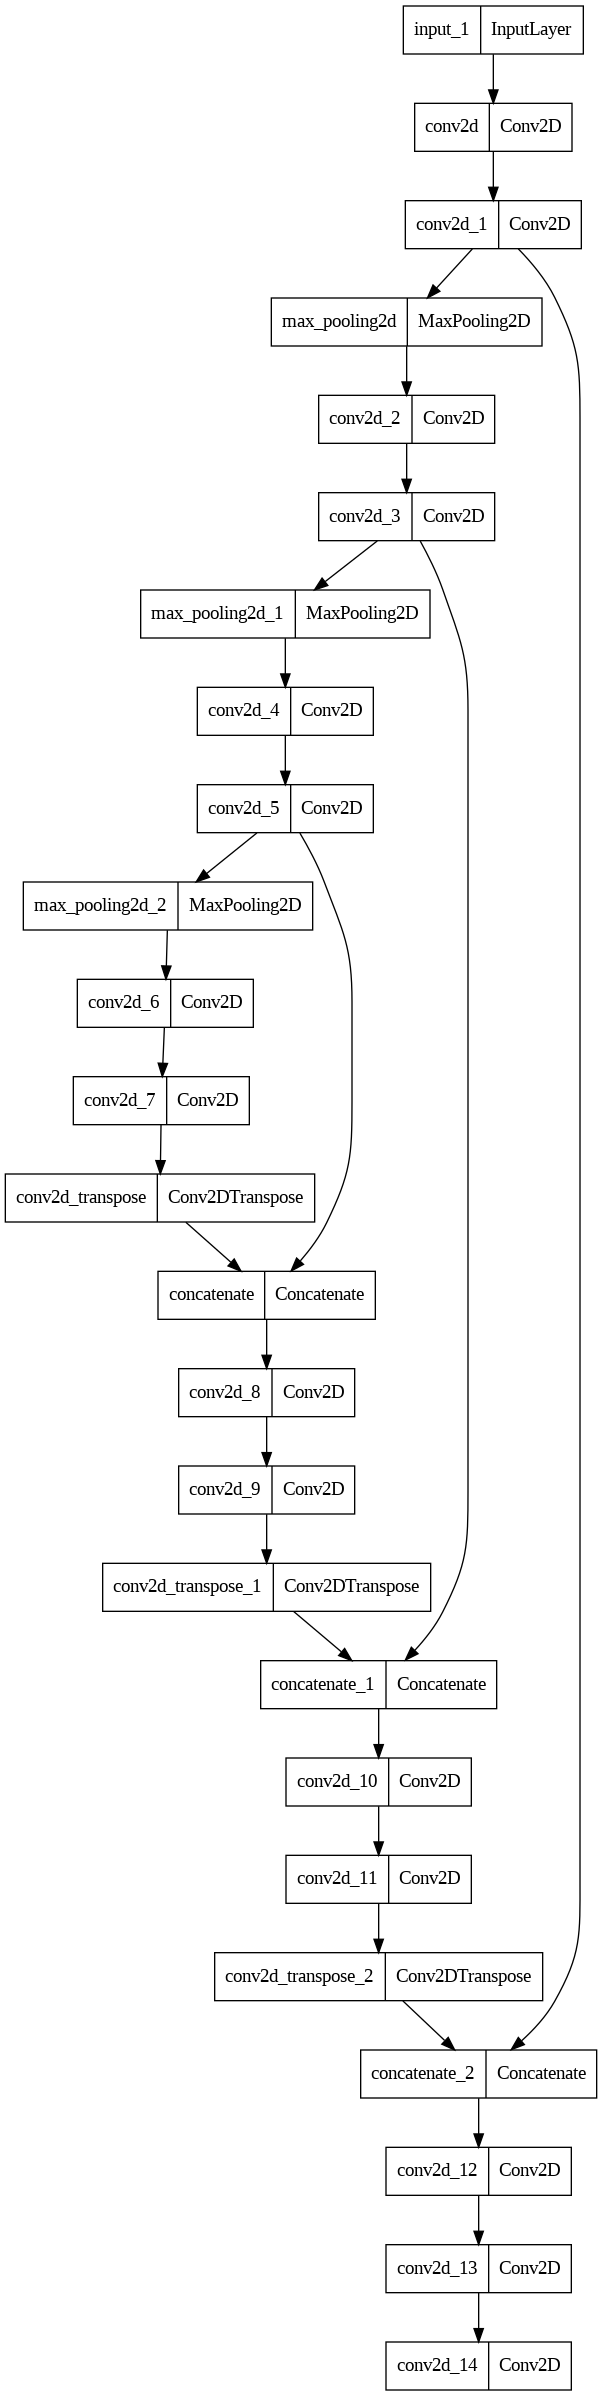

In [41]:
tf.keras.utils.plot_model(best_model)

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=12,
                                            mode='min',
                                            restore_best_weights=True)

history = best_model.fit(X_train, y_train, batch_size=best_params['batch_size'], epochs=100, class_weight=class_weights, validation_split=.2, callbacks=[callback])

Epoch 1/100
53/53 [==============================] - 26s 400ms/step - loss: 1.6381 - accuracy: 0.4120 - IoU: 0.1451 - val_loss: 1.3347 - val_accuracy: 0.6158 - val_IoU: 0.3107
Epoch 2/100
53/53 [==============================] - 14s 266ms/step - loss: 1.2592 - accuracy: 0.6216 - IoU: 0.3490 - val_loss: 1.0722 - val_accuracy: 0.6761 - val_IoU: 0.3566
Epoch 3/100
53/53 [==============================] - 13s 254ms/step - loss: 1.1437 - accuracy: 0.6604 - IoU: 0.3950 - val_loss: 0.9192 - val_accuracy: 0.6994 - val_IoU: 0.3919
Epoch 4/100
53/53 [==============================] - 14s 259ms/step - loss: 1.0815 - accuracy: 0.6851 - IoU: 0.4210 - val_loss: 0.9772 - val_accuracy: 0.7211 - val_IoU: 0.4179
Epoch 5/100
53/53 [==============================] - 13s 253ms/step - loss: 1.0397 - accuracy: 0.7005 - IoU: 0.4456 - val_loss: 0.7666 - val_accuracy: 0.7948 - val_IoU: 0.5152
Epoch 6/100
53/53 [==============================] - 13s 254ms/step - loss: 1.0179 - accuracy: 0.7150 - IoU: 0.4534 - va

In [43]:
y_hat = best_model.predict(X_test)
y_pred = tf.expand_dims(tf.argmax(y_hat, axis=-1), axis=-1)

9/9 [==============================] - 3s 367ms/step


In [44]:
accuracy_score(y_test.reshape(-1), y_pred.numpy().reshape(-1))

0.7898768867112668

In [45]:
m_iou = MeanIoU(num_classes=n_classes)
m_iou.update_state(y_test, y_pred)
m_iou.result().numpy()

0.5472454

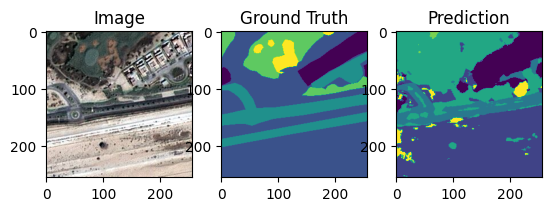

In [52]:
visualize_predictions(X_test, y_test, y_pred, random.randint(0,len(y_test)-1))

##Model evaluation

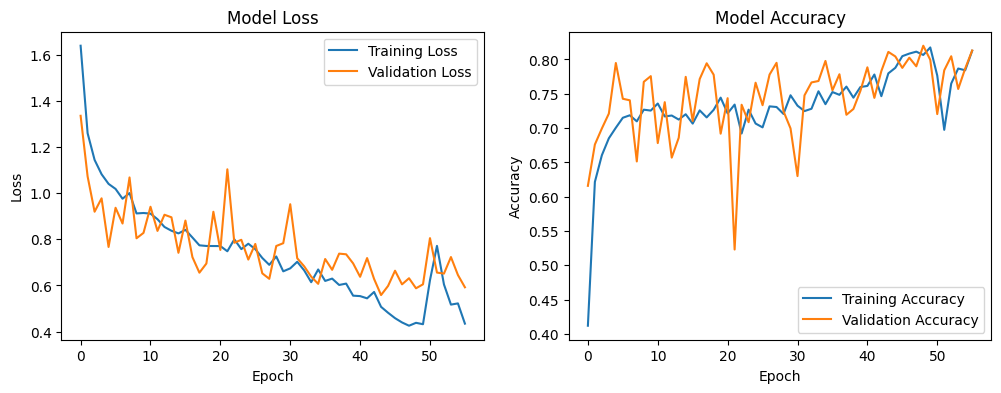

In [53]:
plot_learning_curve(history)

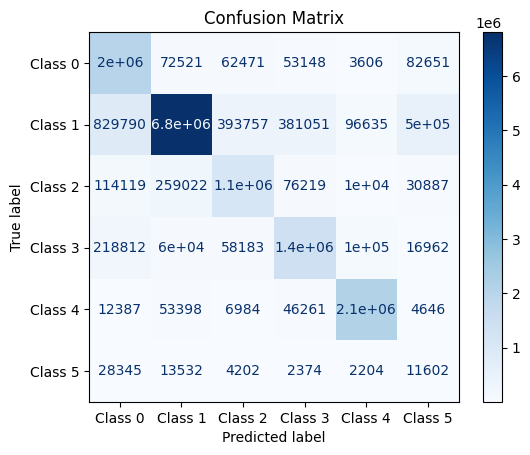

In [54]:
plot_confusion_matrix(y_test, y_pred, n_classes)